**Importing Libraries**

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import scipy.stats as stat
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

**Importing Preprocessed Data**

In [175]:
X_train = pd.read_csv("data/X_train.csv")
X_test = pd.read_csv("data/X_test.csv")
y_train = pd.read_csv("data/y_train.csv")
y_test = pd.read_csv("data/y_test.csv")

In [176]:
X_train.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,...,age:46-52,age:53-59,age:60-67,age:>68,rev:<=0.0132,rev:0.133-0.0545,rev:0.0545-0.154,rev:0.154-0.381,rev:0.381-0.803,rev:0.803-1.355
0,0.851913,49,1,1.913867,0.0,4,3,0,0,0.0,...,1,0,0,0,0,0,0,0,0,1
1,0.227663,40,0,1.913867,0.0,13,0,1,0,3.0,...,0,0,0,0,0,0,0,1,0,0
2,0.043998,76,0,0.016284,10500.0,13,0,0,0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,0.102069,53,0,0.055758,8500.0,5,0,0,0,4.0,...,0,1,0,0,0,0,1,0,0,0
4,1.000000,49,0,0.204955,4600.0,2,1,0,0,1.0,...,1,0,0,0,0,0,0,0,0,1


In [177]:
y_train.head()

,SeriousDlqin2yrs
0,1
1,0
2,0
3,0
4,0


**Checking and Removing Multicollinearity Between Features**

In [178]:
cols = [
    "age",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "NumberOfTimes90DaysLate",
    "NumberOfTime60-89DaysPastDueNotWorse",
    "RevolvingUtilizationOfUnsecuredLines",
]

X_vif = X_train[cols]

vif = pd.Series(
    [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],
    index=X_vif.columns,
    name="VIF",
)

print(vif.round(2))

age                                      1.55
NumberOfTime30-59DaysPastDueNotWorse    36.70
NumberOfTimes90DaysLate                 64.16
NumberOfTime60-89DaysPastDueNotWorse    82.66
RevolvingUtilizationOfUnsecuredLines     1.61
Name: VIF, dtype: float64


As the VIF for 30-59 days, 60-89 days and 90 days+ are all above 5, we will remove the feature with the greater VIF, 60-89 days.

In [179]:
cols = [
    "age",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "NumberOfTimes90DaysLate",
    "RevolvingUtilizationOfUnsecuredLines",
]

X_vif = X_train[cols]

vif = pd.Series(
    [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],
    index=X_vif.columns,
    name="VIF",
)

print(vif.round(2))

age                                      1.55
NumberOfTime30-59DaysPastDueNotWorse    27.52
NumberOfTimes90DaysLate                 27.29
RevolvingUtilizationOfUnsecuredLines     1.57
Name: VIF, dtype: float64


Againt, the VIF for 30-59 days and 90 days+ are larger than 5. We will remove 90 days+

In [180]:
cols = [
    "age",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "RevolvingUtilizationOfUnsecuredLines",
]

X_vif = X_train[cols]

vif = pd.Series(
    [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],
    index=X_vif.columns,
    name="VIF",
)

print(vif.round(2))

age                                     1.53
NumberOfTime30-59DaysPastDueNotWorse    1.02
RevolvingUtilizationOfUnsecuredLines    1.56
Name: VIF, dtype: float64


The VIF for the remaining coefficients are at an acceptable level now

**Filtering For Only The Remaining Selected Features**

In [181]:
X_train.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'age:<37', 'age:38-45', 'age:46-52', 'age:53-59',
       'age:60-67', 'age:>68', 'rev:<=0.0132', 'rev:0.133-0.0545',
       'rev:0.0545-0.154', 'rev:0.154-0.381', 'rev:0.381-0.803',
       'rev:0.803-1.355'],
      dtype='object')

In [182]:
selected_features1 = ['NumberOfTime30-59DaysPastDueNotWorse',
                     'age:<37', 'age:38-45', 'age:46-52', 'age:53-59',
                     'age:60-67', 'age:>68', 'rev:<=0.0132', 'rev:0.133-0.0545',
                     'rev:0.0545-0.154', 'rev:0.154-0.381', 'rev:0.381-0.803',
                     'rev:0.803-1.355']

reference_categories1 = ['age:<37', 'rev:<=0.0132']
#reference_categories = []

In [183]:
X_train_filtered1 = X_train[selected_features1]
X_train_filtered1 = X_train_filtered1.drop(columns = reference_categories1)
X_test_filtered1 = X_test[selected_features1]
X_test_filtered1 = X_test_filtered1.drop(columns = reference_categories1)

In [184]:
X_train_filtered1.head()

,NumberOfTime30-59DaysPastDueNotWorse,age:38-45,age:46-52,age:53-59,age:60-67,age:>68,rev:0.133-0.0545,rev:0.0545-0.154,rev:0.154-0.381,rev:0.381-0.803,rev:0.803-1.355
0,1,0,1,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0,0,0,1


**Fitting Initial Mode**

In [185]:
class LogisticRegression_p_values:
    def __init__(self, *args, **kwargs):
        self.model = LogisticRegression(*args, **kwargs)

    def fit(self, X, y):
        y = np.asarray(y).ravel()

        self.model.fit(X, y)
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_

        # calculate p_values for each coefficient
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom, (X.shape[1], 1)).T
        F_ij = np.dot((X / denom).T, X)
        F_ij_float64 = F_ij.astype(np.float64)
        Cramer_Rao = np.linalg.pinv(F_ij_float64)
        diag = np.diag(Cramer_Rao).copy()
        diag[diag < 0] = 0.0
        sigma_estimates = np.sqrt(diag)
        z_scores = self.coef_[0] / (sigma_estimates + 0.01)
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
        self.p_values = np.append(np.nan, np.round(p_values, 3))

In [186]:
model1 = LogisticRegression_p_values()
model1.fit(X_train_filtered1, y_train)


In [187]:
feature_name = X_train_filtered1.columns.values
summary_table1 = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table1['Coefficients'] = np.transpose(model1.coef_)
summary_table1.index = summary_table1.index + 1
summary_table1.loc[0] = ['Intercept', model1.intercept_[0]]
summary_table1 = summary_table1.sort_index()
summary_table1['p_values'] = model1.p_values
summary_table1['p > 0.05'] = np.where((summary_table1['p_values'] > 0.05), "*", "")

In [188]:
summary_table1

,Feature name,Coefficients,p_values,p > 0.05
0,Intercept,-3.691419,NaN,
1,NumberOfTime30-59DaysPastDueNotWorse,0.027233,0.022,
2,age:38-45,-0.001498,0.972,*
3,age:46-52,-0.018739,0.663,*
4,age:53-59,-0.180495,0.000,
5,age:60-67,-0.491060,0.000,
6,age:>68,-0.818426,0.000,
7,rev:0.133-0.0545,0.000000,1.000,*
8,rev:0.0545-0.154,0.138478,0.025,
9,rev:0.154-0.381,0.685712,0.000,


Remove the statistically insignificant features (age:38-45, age:46-52 and rev:0.0133-0.0545) and fit another fit

**Fitting Second (Final) Model**

In [189]:
selected_features2 = ['NumberOfTime30-59DaysPastDueNotWorse',
                      'NumberOfTime60-89DaysPastDueNotWorse',
                      'NumberOfTimes90DaysLate',
                      'age:<37', 'age:53-59',
                      'age:60-67', 'age:>68', 'rev:<=0.0132',
                      'rev:0.0545-0.154', 'rev:0.154-0.381', 'rev:0.381-0.803',
                      'rev:0.803-1.355']

reference_categories2 = ['age:<37', 'rev:<=0.0132']

In [190]:
X_train_filtered2 = X_train[selected_features2]
X_train_filtered2 = X_train_filtered2.drop(columns = reference_categories2)
X_test_filtered2 = X_test[selected_features2]
X_test_filtered2 = X_test_filtered2.drop(columns = reference_categories2)

In [191]:
model2 = LogisticRegression_p_values()
model2.fit(X_train_filtered2, y_train)

In [192]:
feature_name = X_train_filtered2.columns.values
summary_table2 = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table2['Coefficients'] = np.transpose(model2.coef_)
summary_table2.index = summary_table2.index + 2
summary_table2.loc[0] = ['Intercept', model2.intercept_[0]]
summary_table2 = summary_table2.sort_index()
summary_table2['p_values'] = model2.p_values
summary_table2['p > 0.05'] = np.where((summary_table2['p_values'] > 0.05), "*", "")
summary_table2

,Feature name,Coefficients,p_values,p > 0.05
0,Intercept,-3.746458,NaN,
2,NumberOfTime30-59DaysPastDueNotWorse,0.343102,0.000,
3,NumberOfTime60-89DaysPastDueNotWorse,-0.623401,0.000,
4,NumberOfTimes90DaysLate,0.304268,0.000,
5,age:53-59,-0.196659,0.000,
6,age:60-67,-0.483823,0.000,
7,age:>68,-0.785975,0.000,
8,rev:0.0545-0.154,0.143216,0.015,
9,rev:0.154-0.381,0.641227,0.000,
10,rev:0.381-0.803,1.439760,0.000,


In [193]:
model = model2.model
y_train_pred = model.predict(X_train_filtered2)
y_train_proba_pos = model.predict_proba(X_train_filtered2)[:, 1]

y_test_pred = model.predict(X_test_filtered2)
y_test_proba_pos  = model.predict_proba(X_test_filtered2)[:, 1]

**Evaluating the Model**

Confusion Matrix

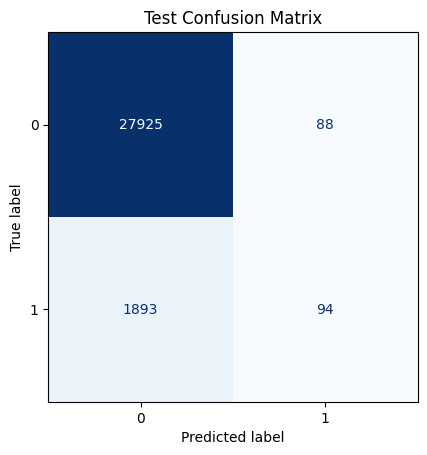

In [194]:
cm_test  = confusion_matrix(y_test , y_test_pred )

disp = ConfusionMatrixDisplay(cm_test, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format="d", colorbar=False)
plt.title('Test Confusion Matrix')
plt.show()

ROC-AUC

In [195]:
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("ROC‑AUC  :", roc_auc_score(y_test, y_test_proba_pos))
print(classification_report(y_test, y_test_pred, digits=3))

Accuracy : 0.9339666666666666
ROC‑AUC  : 0.800566379140492
              precision    recall  f1-score   support

           0      0.937     0.997     0.966     28013
           1      0.516     0.047     0.087      1987

    accuracy                          0.934     30000
   macro avg      0.726     0.522     0.526     30000
weighted avg      0.909     0.934     0.908     30000



The model achieves an ROC-AUC of 0.80, meaning it is much better than random guessing. However, it can be seen from the classification summary that the recall for predicting class 1 is incredly low, at 0.047, meaning only 4.7% of all class 1 are accurately predicted.

Text(0.5, 1.0, 'ROC Curve')

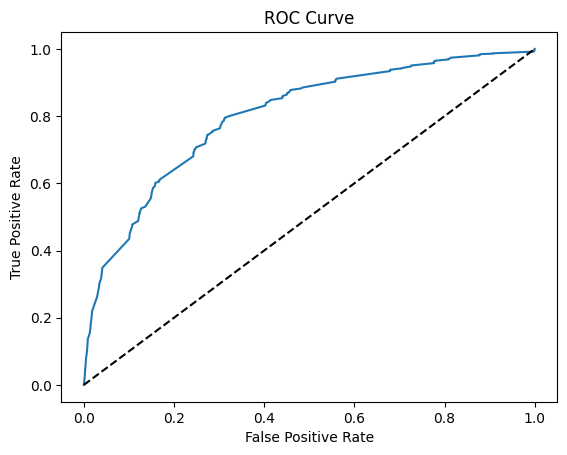

In [196]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test.copy(), y_test_proba_pos)

plt.plot(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, false_positive_rate, linestyle = '--', color = 'k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')